In [19]:
# Import required libraries
from PIL import Image
import os
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from sklearn.metrics import confusion_matrix

In [21]:
# Cleanup previous dataset directories if they exist
!rm -rf Scratched_Cars/
!rm -rf Undamaged_Cars/
!rm -rf best_checkpoint/
!rm -rf data1a/
!rm -rf dataset/
!rm best_checkpoint.zip

rm: cannot remove 'best_checkpoint.zip': No such file or directory


In [22]:
# Create a new directory for dataset zips and copy datasets
!mkdir dataset_zip

# Unzip datasets and organize them into respective folders
!unzip -qo dataset_zip/Scratched_Cars/Scratched_Cars.zip
!cp -r dataset_zip/Undamaged_Cars/Undamaged_Cars Undamaged_Cars
!rm -rf dataset_zip  # Clean up the zip directory after extraction

unzip:  cannot find or open dataset_zip/Undamaged_Cars/Undamaged_Cars.zip, dataset_zip/Undamaged_Cars/Undamaged_Cars.zip.zip or dataset_zip/Undamaged_Cars/Undamaged_Cars.zip.ZIP.


In [23]:
# Function to check and remove any invalid image files in a folder
def check_images_in_folder(folder_path):
    valid_images = []
    invalid_images = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            with Image.open(file_path) as img:
                img.verify()  # Verify if it's an image. This is important as some are corrupted
            valid_images.append(filename)
        except (IOError, SyntaxError) as e:
            invalid_images.append(filename)
    return invalid_images

# Function to get all valid image paths from a directory
def get_image_paths(directory):
    """Get all image paths in a given directory."""
    return [os.path.join(directory, file) for file in os.listdir(directory) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Function to undersample image paths from two directories for balanced classes
def undersample_paths(dir1, dir2):
    """Undersample image paths from two directories to create balanced classes."""
    paths1 = get_image_paths(dir1)
    paths2 = get_image_paths(dir2)
    min_count = min(len(paths1), len(paths2))
    paths1 = random.sample(paths1, min_count) if len(paths1) > min_count else paths1
    paths2 = random.sample(paths2, min_count) if len(paths2) > min_count else paths2
    return paths1, paths2

# Function to split dataset paths into train, test, and validation sets
def split_data(paths, train_ratio, test_ratio):
    """Split data into train, test, and validation sets."""
    random.shuffle(paths)
    train_size = int(len(paths) * train_ratio)
    test_size = int(len(paths) * test_ratio)
    train_paths = paths[:train_size]
    test_paths = paths[train_size:train_size + test_size]
    val_paths = paths[train_size + test_size:]
    return train_paths, test_paths, val_paths

# Function to copy files to a specified destination
def copy_files(file_paths, destination):
    """Copy files to a specified destination."""
    for path in file_paths:
        shutil.copy(path, destination)

# Define the class names and dataset directory structure
class_names = ['Scratched_Cars', 'Undamaged_Cars']
dataset_base = 'dataset'
subfolders = ['train', 'test', 'validation']

# Remove invalid images from each class directory
for folder in class_names:
  invalid_images = check_images_in_folder(folder)
  for invalid_image in invalid_images:
    os.remove(os.path.join(folder, invalid_image))
    print("Removed invalid image:", os.path.join(folder, invalid_image))

# Get balanced paths for each class and prepare the dataset directory structure
balanced_paths1, balanced_paths2 = undersample_paths(class_names[0], class_names[1])
for subfolder in subfolders:
    os.makedirs(os.path.join(dataset_base, subfolder), exist_ok=True)
    for class_name in class_names:
        os.makedirs(os.path.join(dataset_base, subfolder, class_name), exist_ok=True)

# Split and copy the data for each class into the dataset structure
for idx, paths in enumerate([balanced_paths1, balanced_paths2]):
    train, test, val = split_data(paths, train_ratio=0.7, test_ratio=0.1)
    copy_files(train, os.path.join(dataset_base, 'train', class_names[idx]))
    copy_files(test, os.path.join(dataset_base, 'test', class_names[idx]))
    copy_files(val, os.path.join(dataset_base, 'validation', class_names[idx]))

print("Data successfully split and copied into the dataset folder.")

Removed invalid image: Undamaged_Cars/DPt8y4MuGLLqrM.jpg
Removed invalid image: Undamaged_Cars/njbaSQCRRyICzM.jpg
Removed invalid image: Undamaged_Cars/nPI1plBku-ZD1M.jpg
Removed invalid image: Undamaged_Cars/Zp5HSkz4B2prRM.jpg
Removed invalid image: Undamaged_Cars/tMz-ivnVKZubCM.jpg
Removed invalid image: Undamaged_Cars/50PYbIvq7UBYhM.jpg
Data successfully split and copied into the dataset folder.


In [24]:
# Function to create a dataset from a directory
def create_dataset_from_dir(dir):
    """Create a dataset from the given directory with specified parameters."""
    dataset = tf.keras.utils.image_dataset_from_directory(
        dir,
        labels="inferred",  # Automatically infer labels from directory structure
        label_mode="categorical",  # For multi-class classification
        color_mode="rgb",  # Use RGB images
        batch_size=16,  # Number of samples per batch
        image_size=(224, 224),  # Resize images to 224x224
        shuffle=True,  # Shuffle the data
        seed=42,  # Seed for shuffling and transformations
        interpolation="bilinear"  # Interpolation method for resizing
    )
    return dataset

# Load the datasets
print("Training:")
training_set = create_dataset_from_dir('dataset/train');
print("\nValidation:")
validation_set = create_dataset_from_dir('dataset/validation');
print("\nTesting:")
testing_set = create_dataset_from_dir('dataset/test');

Training:
Found 444 files belonging to 2 classes.

Validation:
Found 130 files belonging to 2 classes.

Testing:
Found 62 files belonging to 2 classes.


In [25]:
# Display some metadata about the datasets
print("Classes:", training_set.class_names)  # Print class names
print("Number of batches:", len(training_set))  # Print the number of batches in the training set

# Example of accessing and printing metadata for a single batch
for images, labels in training_set.take(1):  # Access a single batch
    print("Batch shape:", images.shape)  # Print shape of the batch (images)
    print("Label shape:", labels.shape)  # Print shape of the labels
    print("First 10 labels in the first batch:", labels[:10])  # Print first 10 labels of the batch

Classes: ['Scratched_Cars', 'Undamaged_Cars']
Number of batches: 28
Batch shape: (16, 224, 224, 3)
Label shape: (16, 2)
First 10 labels in the first batch: tf.Tensor(
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]], shape=(10, 2), dtype=float32)


In [26]:
# Setup the model checkpoint callback
checkpoint = ModelCheckpoint(
    './best_checkpoint',  # Path where to save the model
    monitor='val_accuracy',  # Monitor validation accuracy for improvement
    verbose=1,  # Verbosity mode
    save_best_only=True,  # Save only the best model
    mode='max',  # Maximize the monitored metric (val_accuracy)
    save_weights_only=False,  # Save the entire model, not just weights
    save_frequency=1  # Checkpoint saving frequency
)

In [27]:
# Setup the early stopping callback
earlystop = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss for stopping
    min_delta=0.001,  # Minimum change to qualify as an improvement
    patience=50,  # How many epochs to wait after last time val_loss improved
    verbose=1,  # Verbosity mode
    mode='auto'  # The direction of monitoring (auto detects automatically)
)

In [28]:
def upload_misclassified_images(testing_set, model):
    """
    Save images that were misclassified by the model during testing.

    Args:
        testing_set: The dataset used for testing the model.
        model: The trained TensorFlow model.

    Returns:
        A list of tuples containing the path to misclassified images, their true labels, and the predicted labels.
    """
    labels = ["00-scratched", "01-whole"]
    output_dir = 'misclassified_images'  # Directory to save misclassified images
    os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

    image_info = []  # Store info of misclassified images

    # Iterate over all batches in the testing set
    for batch_index, (images, truths) in enumerate(testing_set):
        predictions = model.predict(images)  # Predict a whole batch for efficiency
        for i, image in enumerate(images):
            prediction = np.argmax(predictions[i])
            truth = np.argmax(truths[i])
            if prediction != truth:
                # Save misclassified image
                image_path = os.path.join(output_dir, f'image_{batch_index}_{i}.jpg')
                tf.keras.utils.save_img(image_path, image.numpy())
                # Append misclassification info
                image_info.append((image_path, labels[truth], labels[prediction]))

    return image_info

In [29]:
def plot_test_images(testing_set, model):
    """
    Plot a 3x3 grid of images from the testing set with their true and predicted labels.

    Args:
        testing_set: The dataset used for testing the model.
        model: The trained TensorFlow model.
    """
    labels = ["00-scratched", "01-whole"]

    it = iter(testing_set)
    images, truths = next(it)  # Get a batch of test images and labels

    predictions = model.predict(images)  # Predict the entire batch for efficiency

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.tight_layout()
    fig.subplots_adjust(hspace=.25)

    for i in range(3):
        for j in range(3):
            ax = axes[i, j]
            image = images[i * 3 + j]
            truth = np.argmax(truths[i * 3 + j])
            prediction = np.argmax(predictions[i * 3 + j])
            ax.set_title('Label: %s\nPrediction: %s' % (labels[truth], labels[prediction]))
            ax.imshow(image.numpy().astype("uint8"))
            ax.axis('off')  # Hide the axis

    return fig

In [30]:
def plot_confusion_matrix(testing_set, model, labels=["00-scratched", "01-whole"]):
    """
    Plot a confusion matrix for the model predictions on the testing set.

    Args:
        testing_set: The dataset used for testing the model.
        model: The trained TensorFlow model.
        labels: A list of label names corresponding to the classification labels.
    """
    true_labels = []  # True labels
    pred_labels = []  # Predicted labels

    # Iterate through the testing set
    for images, truths in testing_set:
        predictions = model.predict(images)  # Predict the entire batch for efficiency
        true_labels.extend(np.argmax(truths, axis=1))
        pred_labels.extend(np.argmax(predictions, axis=1))

    # Generate and plot the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', xticklabels=labels, yticklabels=labels)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    plt.show()

    return fig

Epoch 1/15
28/28 [==============================] - ETA: 0s - loss: 14.3466 - accuracy: 0.7838 
Epoch 1: val_accuracy improved from -inf to 0.93846, saving model to ./best_checkpoint
28/28 [==============================] - 449s 16s/step - loss: 14.3466 - accuracy: 0.7838 - val_loss: 4.3237 - val_accuracy: 0.9385
Epoch 2/15
28/28 [==============================] - ETA: 0s - loss: 10.5874 - accuracy: 0.8784 
Epoch 2: val_accuracy did not improve from 0.93846
28/28 [==============================] - 367s 13s/step - loss: 10.5874 - accuracy: 0.8784 - val_loss: 4.3102 - val_accuracy: 0.9308
Epoch 3/15
28/28 [==============================] - ETA: 0s - loss: 6.6344 - accuracy: 0.9324 
Epoch 3: val_accuracy did not improve from 0.93846
28/28 [==============================] - 371s 13s/step - loss: 6.6344 - accuracy: 0.9324 - val_loss: 4.4297 - val_accuracy: 0.9077
Epoch 4/15
28/28 [==============================] - ETA: 0s - loss: 4.8496 - accuracy: 0.9369 
Epoch 4: val_accuracy did not impr

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 38s 9s/step - loss: 11.9172 - accuracy: 0.9194
Test loss: 11.917245864868164, Test accuracy: 0.9193548560142517
1/1 [==============================] - 7s 7s/step


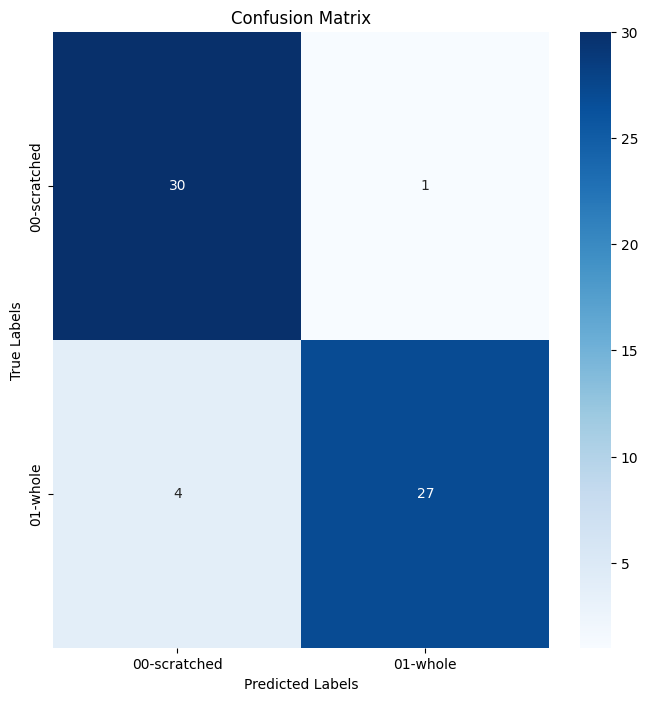

1/1 [==============================] - 10s 10s/step


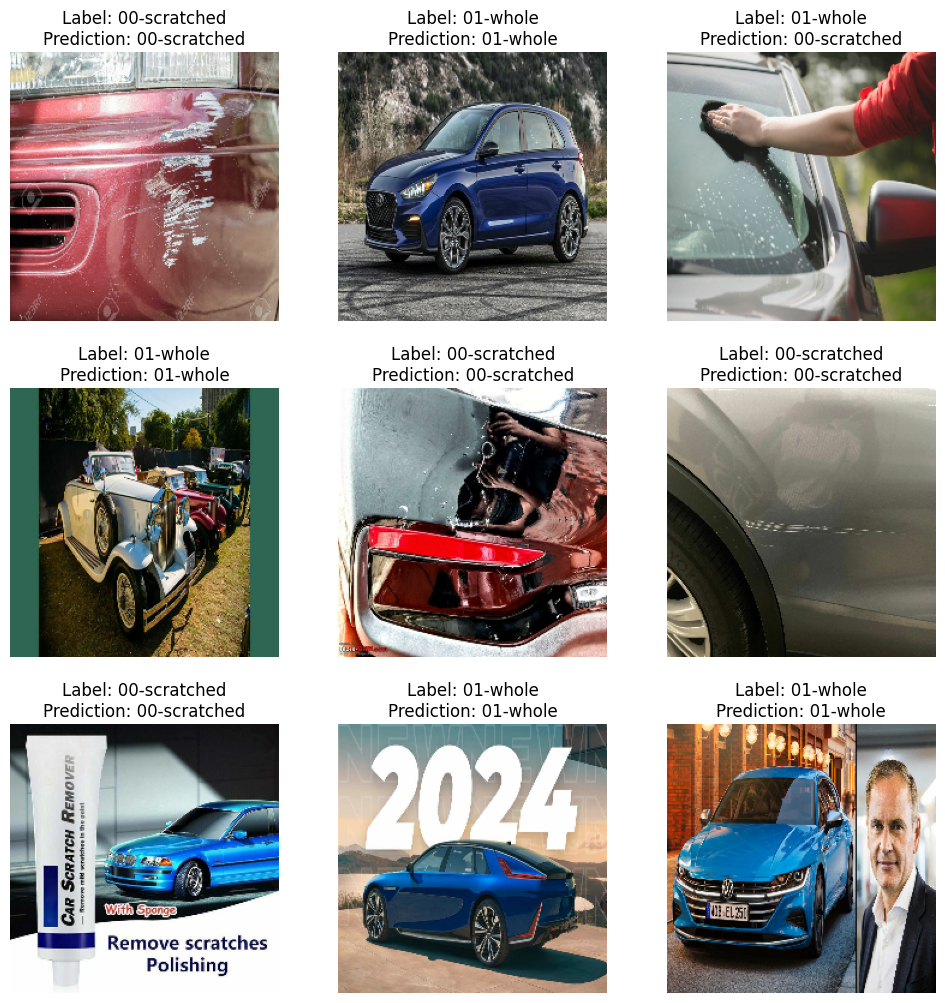

1/1 [==============================] - 9s 9s/step


NameError: name 'misclassified_images_info' is not defined

In [31]:
# Define the model architecture using VGG16 as a base model
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the layers of the base model to not train them during the first training phase
for layer in base_model.layers:
    layer.trainable = False

# Building the model by adding custom layers on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax') 
])

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# Define your callbacks 
callbacks = [checkpoint, earlystop]

# Fit the model on the training data
history = model.fit(training_set,
                    epochs=15,
                    validation_data=validation_set,
                    callbacks=callbacks)

# After training, save the model and/or its weights locally
model.save('best_model.h5')  # Save the entire model as a single HDF5 file.

# Optionally, create a zip file of your model directory if you have saved checkpoints
import shutil
shutil.make_archive("best_checkpoint", 'zip', "best_checkpoint")

# Evaluate the model on the test set
loss, accuracy = model.evaluate(testing_set)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

# Plotting the confusion matrix for the test set
fig_cm = plot_confusion_matrix(testing_set, model)
plt.show(fig_cm)

# Plot test images with predictions
fig_test_images = plot_test_images(testing_set, model)
plt.show(fig_test_images)

# Upload misclassified images
misclass = upload_misclassified_images(testing_set, model)
for img_info in misclassified_images_info:
    print(f"Misclassified Image: {img_info[0]}, True Label: {img_info[1]}, Predicted Label: {img_info[2]}")

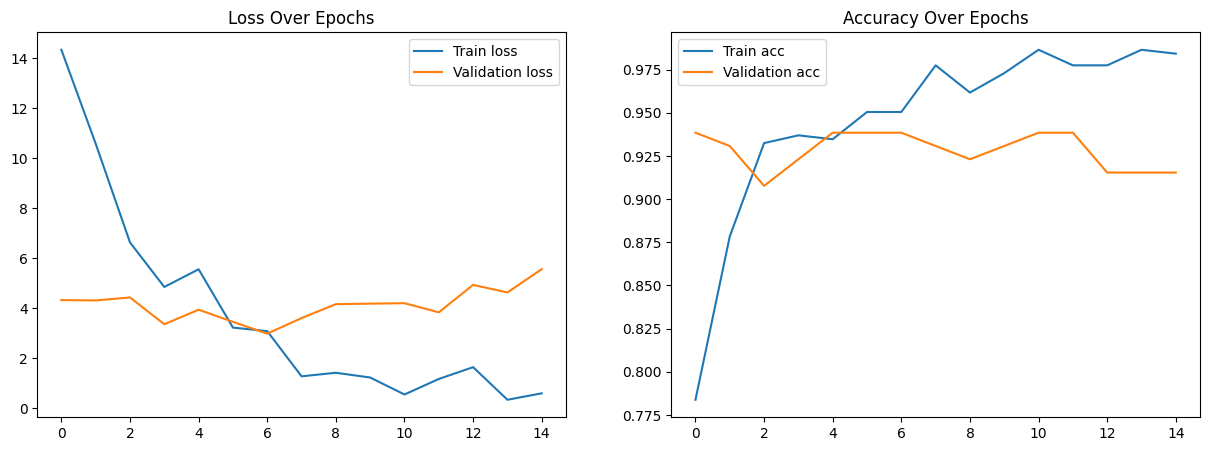

In [33]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('Loss Over Epochs')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('Accuracy Over Epochs')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

show_final_history(history)